In [115]:
import ujson as json
from itertools import chain
import sentencepiece as spm
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
from collections import Counter
from sklearn.preprocessing import RobustScaler, PowerTransformer

VOCAB_SIZE = 32000

In [116]:
with open('../movie_data.json', 'r') as f:
    data = json.load(f)

In [117]:
for i in range(len(data)):
    data[i]['story'] = data[i]['story'].replace('제작노트 보기', '')
    
data = [d for d in data if 1 <= len(d['actors']) <= 64 and 1 <= len(d['directors']) <= 8]
data = [d for d in data if 1 < d['netizen_score'] < 10]

In [118]:
categories = set(chain(*[d['categories'] for d in data]))
category2id = {c: i for i, c in enumerate(categories)}

countries = set(chain(*[d['countries'] for d in data]))
country2id = {c: i for i, c in enumerate(countries)}

for i in range(len(data)):
    data[i]['categories_id'] = [category2id[category] for category in data[i]['categories']]
    data[i]['countries_id'] = [country2id[country] for country in data[i]['countries']]

In [119]:
indices = np.arange(len(data))
train_indices, test_indices = train_test_split(indices, train_size=0.8)
valid_indices, test_indices = train_test_split(test_indices, train_size=0.5)

train_data = sorted([data[i] for i in train_indices], key=lambda x: x['netizen_score'], reverse=True)
valid_data = sorted([data[i] for i in valid_indices], key=lambda x: x['netizen_score'], reverse=True)
test_data = sorted([data[i] for i in test_indices], key=lambda x: x['netizen_score'], reverse=True)

In [120]:
with open('./story.txt', 'w') as f:
    for d in train_data:
        f.write(f"{d['story']}\n")

spm.SentencePieceProcessor()
spm.SentencePieceTrainer.Train(
    f'--input=./story.txt --model_prefix=./m --vocab_size={VOCAB_SIZE} '
    f'--character_coverage=0.9996 --split_by_whitespace=true --pad_id=0 --bos_id=-1 --unk_id=1')

True

In [121]:
sp = spm.SentencePieceProcessor()
sp.Load('./m.model')

for i in range(len(train_data)):
    train_data[i]['story_parsed'] = sp.encode_as_ids(train_data[i]['story'])
    
for i in range(len(valid_data)):
    valid_data[i]['story_parsed'] = sp.encode_as_ids(valid_data[i]['story'])
    
for i in range(len(test_data)):
    test_data[i]['story_parsed'] = sp.encode_as_ids(test_data[i]['story'])

In [122]:
actors = Counter(chain(*[[actor['code'] for actor in d['actors']] for d in train_data]))
actors = [a for a, c in actors.items() if c >= 2]
actors.insert(0, 'Unknown_Actor')
actors.insert(0, '<PAD>')
actor2id = {actor_code: index for index, actor_code in enumerate(actors)}

directors = Counter(chain(*[[director['code'] for director in d['directors']] for d in train_data]))
directors = [d for d, c in directors.items() if c >= 2]
directors.insert(0, 'Unknown_Director')
directors.insert(0, '<PAD>')
director2id = {director_code: index for index, director_code in enumerate(directors)}

# for train dataset
scaler = RobustScaler()
data_transformer = PowerTransformer()
scores = np.array([d['netizen_score'] for d in train_data])/10
scores = data_transformer.fit_transform(scaler.fit_transform(scores.reshape(-1, 1))).reshape(-1)

for i in range(len(train_data)):
    for k in range(len(train_data[i]['actors'])):
        train_data[i]['actors'][k]['id'] = actor2id.get(train_data[i]['actors'][k]['code'], 1)
        
    for k in range(len(train_data[i]['directors'])):
        train_data[i]['directors'][k]['id'] = director2id.get(train_data[i]['directors'][k]['code'], 1)
        
    train_data[i]['score'] = scores[i]


# for valid dataset
scores = np.array([d['netizen_score'] for d in valid_data])/10
scores = data_transformer.transform(scaler.transform(scores.reshape(-1, 1))).reshape(-1)
for i in range(len(valid_data)):
    for k in range(len(valid_data[i]['actors'])):
        valid_data[i]['actors'][k]['id'] = actor2id.get(valid_data[i]['actors'][k]['code'], 1)
        
    for k in range(len(valid_data[i]['directors'])):
        valid_data[i]['directors'][k]['id'] = director2id.get(valid_data[i]['directors'][k]['code'], 1)
        
    valid_data[i]['score'] = scores[i]
    

# for test dataset
scores = np.array([d['netizen_score'] for d in test_data])/10
scores = data_transformer.transform(scaler.transform(scores.reshape(-1, 1))).reshape(-1)
for i in range(len(test_data)):
    for k in range(len(test_data[i]['actors'])):
        test_data[i]['actors'][k]['id'] = actor2id.get(test_data[i]['actors'][k]['code'], 1)
        
    for k in range(len(test_data[i]['directors'])):
        test_data[i]['directors'][k]['id'] = director2id.get(test_data[i]['directors'][k]['code'], 1)

    test_data[i]['score'] = scores[i]

In [123]:
vocab = []
with open('./m.vocab', 'r') as f:
    for line in f:
        vocab.append(line.split('\t')[0])
        
with open('../meta_data.pkl', 'wb') as f:
    pickle.dump({
        'vocab': vocab,
        'categories': categories,
        'countries': countries,
        'actors': actors,
        'directors': directors,
        'scaler': scaler,
        'data_transformer': data_transformer
    }, f)
with open('../train_data.json', 'w') as f:
    json.dump(train_data, f)
    
with open('../valid_data.json', 'w') as f:
    json.dump(valid_data, f)
    
with open('../test_data.json', 'w') as f:
    json.dump(test_data, f)

In [124]:
print(len(data), len(train_data), len(valid_data), len(test_data))

13236 10588 1324 1324


In [172]:
[(d['name'], d['netizen_score']) for d in train_data if '전쟁' in d['categories']][:20]

[('창공에 산다', 9.5),
 ('아일라', 9.5),
 ('일송정 푸른 솔은', 9.48),
 ('작은 전쟁', 9.47),
 ('캡틴 스터비', 9.42),
 ('라이언 일병 구하기', 9.39),
 ('반지의 제왕: 왕의 귀환', 9.37),
 ('한나스 워', 9.36),
 ('쉰들러 리스트', 9.35),
 ('피아니스트', 9.31),
 ('만무방', 9.29),
 ('포화속의 우정', 9.28),
 ('공동경비구역 JSA', 9.27),
 ('브레이브하트', 9.26),
 ('바람과 함께 사라지다', 9.22),
 ('란', 9.22),
 ('랜드 앤 프리덤', 9.22),
 ('랜드 오브 마인', 9.21),
 ('핵소 고지', 9.21),
 ('크미치스', 9.2)]

In [173]:
[(d['name'], d['netizen_score']) for d in train_data if '액션' in d['categories']][:20]

[('욤욤 공주와 도둑', 9.88),
 ('돌아온 소림사 주방장', 9.8),
 ('사망탑의 결전', 9.71),
 ('포드 V 페라리', 9.57),
 ('라 미나스', 9.54),
 ('황혼의 검객', 9.5),
 ('바람과 야망', 9.5),
 ('열혈천사', 9.5),
 ('좀비 : 죽은 자들의 도시', 9.5),
 ('구마도장', 9.5),
 ('프로젝트 A', 9.48),
 ('당갈', 9.45),
 ('터미네이터 2:오리지널', 9.43),
 ('맹룡과강', 9.42),
 ('태극권', 9.4),
 ('글래디에이터', 9.39),
 ('라이언 일병 구하기', 9.39),
 ('쿵푸마스터', 9.38),
 ('어벤져스: 엔드게임', 9.38),
 ('반지의 제왕: 왕의 귀환', 9.37)]

In [175]:
test_data[0]

{'name': '메기의 추억',
 'netizen_score': 9.9,
 'categories': ['드라마'],
 'countries': ['한국'],
 'runtime': 102,
 'story': '서울 변두리 공원 공터에 매일 노인들이 모여서 소일을 하고 있다. 흡사 화창한 봄날, 소풍을 나오것처럼... 100세 시대를 맞이하였지만 사회와 가족에게 소외 당하고 복지의 사각지대에서 살아가는 노인들의 애환이 점묘된다. 그 공원 한쪽에서 구슬픈 바이올린으로 흘러간 명곡 ‘메기의 추억’을 연주하는 마노인(80세)의 앞에는 몇푼의 지폐와 동전이 외롭게 던져 진다. 마노인은 낡은 바이올린 하나로 연주를 하며 생계를 유지하는 떠돌이 악사였다. 그런 마노인을 바라보던 추노파(75세)가 갑자기 “내 남편, 허삼도... 나이는 마흔세살, 내 남편!“이라고 덤벼 들자 놀라는 마노인이 연주를 멈추고 당황을 한다. 생면부지의 추노파는 정신이 들락 거리는 치매 환자였다. 어느날 동네 시장통에서 동네 사람들에게 희롱을 당하는 추노파를 귀가하던 마노인이 위기에서 구해준다. 이것이 인연이 된다. 마노인은 몇십년째 살고 있는 옛집에서 늘 사고나 치고 집 나간지 몇 년이 된 외아들 덕배(40세)만을 기다리며 살아가는 독고노인이였다. 한편 추노파는 겉으로는 다복한 가정이지만 악독한 며느리에게 괄세를 받고 사는 치매 노파로 죽지 못해 살아가는 형편이다. 들락거리는 치매로 집안에서 허구헌날 치매환자로 사고를 친다. 단, 하나 유일하게 추노파를 챙겨 주는 손녀 효순(10세)가 있기에 들락 거리는 치매 현상을 극복하며 살아가는데... ',
 'actors': [{'code': '367923', 'name': '정인철', 'part': ['주연'], 'id': 1},
  {'code': '410903', 'name': '전채련', 'part': ['주연'], 'id': 1},
  {'code': '412607', 'name': '이동욱', 'part': ['주연'], 'id': 1},
  {'

In [88]:
scores = np.array([d['netizen_score'] for d in train_data])

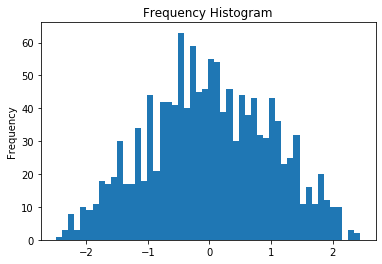

In [101]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Plot Histogram on x
transformer = RobustScaler()
transformer2 = PowerTransformer()
scores = transformer.fit_transform(scores.reshape(-1, 1)).reshape(-1)
scores = transformer2.fit_transform(scores.reshape(-1, 1)).reshape(-1)
plt.hist(scores, bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

In [109]:
np.mean(scores >= 0.5)

0.324773413897281

In [110]:
np.mean(scores <= -0.5)

0.31268882175226587